# Modélisation et évaluation des modèles

Ce notebook entraîne et évalue différents modèles de Machine Learning pour la classification de sentiment sur les données de tweets prétraitées.

## 1- Importation des librairies

In [1]:
# Imports standards (bibliothèques intégrées à Python)
import sys
import os
import pickle  # Pour la sauvegarde et le chargement de modèles et d'objets Python

# Manipulation et traitement de données
import pandas as pd
import numpy as np

# Machine Learning
    # Scikit-learn (modèles, métriques, utilitaires)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

    # TensorFlow/Keras (modèles de deep learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten  # Couches Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # Pour le padding des séquences
from tensorflow.keras.optimizers.schedules import ExponentialDecay # Pour la décroissance du taux d'apprentissage

    # Hugging Face Transformers (modèles pré-entraînés)
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Gensim (Word2Vec, FastText, Doc2Vec - embeddings)
from gensim.models import Word2Vec, FastText

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow (suivi des expériences)
import mlflow
import mlflow.sklearn  # Intégration MLflow pour scikit-learn
import mlflow.keras    # Intégration MLflow pour Keras
from mlflow.models import infer_signature
import tensorflow_hub as hub

# Imports de modules locaux (personnalisés)
sys.path.append('../src')
import model  
import evaluation  


2025-02-15 22:28:08.900796: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 22:28:10.408764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 22:28:11.339254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739654892.216802    6975 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739654892.408333    6975 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 22:28:14.043778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 2. Chargement des données

In [2]:
#@title 2.1 Chargement des données

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Charger les données prétraitées

## Données non vectorisées
X_train = pickle.load(open(data_path + 'X_train.pickle', 'rb'))
X_test = pickle.load(open(data_path + 'X_test.pickle', 'rb'))

## Labels
y_train = pickle.load(open(data_path + 'y_train.pickle', 'rb'))
y_test = pickle.load(open(data_path + 'y_test.pickle', 'rb'))

## Vectorisées TF-IDF
X_train_tfidf = pickle.load(open(data_path + 'X_train_tfidf.pickle', 'rb'))
X_test_tfidf = pickle.load(open(data_path + 'X_test_tfidf.pickle', 'rb'))

## Word2vec
X_train_w2v = pickle.load(open(data_path + 'X_train_word2vec.pickle', 'rb'))
X_test_w2v = pickle.load(open(data_path + 'X_test_word2vec.pickle', 'rb'))


## Doc2Vec
X_train_d2v = pickle.load(open(data_path + 'X_train_doc2vec.pickle', 'rb'))
X_test_d2v = pickle.load(open(data_path + 'X_test_doc2vec.pickle', 'rb'))


In [3]:
#@title Affichage des dimensions des données

print("Dimensions des données non vectorisées:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")
print("-" * 30)

print("Dimensions des données TF-IDF:")
print(f"  X_train_tfidf: {X_train_tfidf.shape}")
print(f"  X_test_tfidf: {X_test_tfidf.shape}")
print("-" * 30)

print("Dimensions des données Word2Vec:")
print(f"  X_train_w2v: {X_train_w2v.shape}")
print(f"  X_test_w2v: {X_test_w2v.shape}")
print("-" * 30)

print("Dimensions des données Doc2Vec:")
print(f"  X_train_d2v: {X_train_d2v.shape}")
print(f"  X_test_d2v: {X_test_d2v.shape}")

Dimensions des données non vectorisées:
  X_train: (128000,)
  X_test: (32000,)
  y_train: (128000,)
  y_test: (32000,)
------------------------------
Dimensions des données TF-IDF:
  X_train_tfidf: (128000, 1000)
  X_test_tfidf: (32000, 1000)
------------------------------
Dimensions des données Word2Vec:
  X_train_w2v: (128000, 500)
  X_test_w2v: (32000, 500)
------------------------------
Dimensions des données Doc2Vec:
  X_train_d2v: (128000, 500)
  X_test_d2v: (32000, 500)


## 3. Entraînement et évaluation des modèles

### 3.1.1 - Logreg + TFIdf (Baseline)

Accuracy: 0.7504
Precision: 0.7299
Recall: 0.7946
F1-score: 0.7609
Prediction Time: 0.0050 seconds


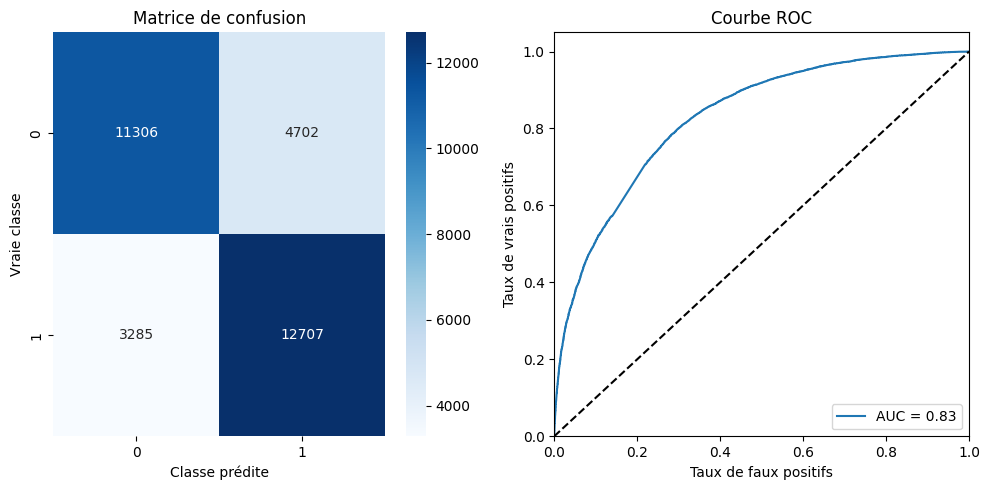

Registered model 'modele_lr' already exists. Creating a new version of this model...
Created version '9' of model 'modele_lr'.


In [4]:
# Créer et entraîner le modèle de régression logistique
model_lr = LogisticRegression(solver='liblinear', max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr.fit(X_train_tfidf, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr, X_test_tfidf, y_test)
    
    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression")

    # Enregistrer le modèle avec pickle
    with open('../models/model_lr.pkl', 'wb') as f:
        pickle.dump(model_lr, f)
        
    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr,
                             "model_lr",
                            input_example =  X_train_tfidf[:5],
                            registered_model_name="modele_lr")



### 3.1.2 - Logreg + Doc2Vec

Accuracy: 0.6938
Precision: 0.6947
Recall: 0.6912
F1-score: 0.6929
Prediction Time: 0.1842 seconds


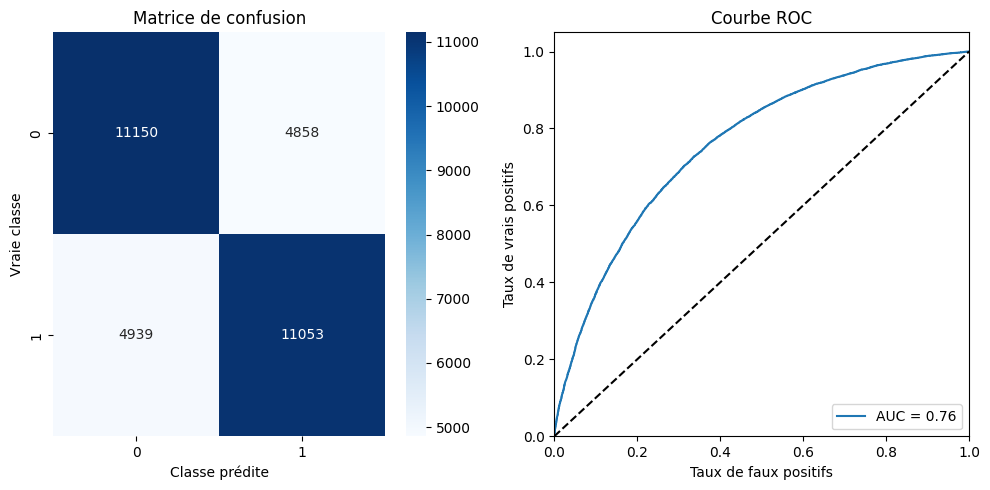

Registered model 'model_lr_doc2vec' already exists. Creating a new version of this model...
Created version '4' of model 'model_lr_doc2vec'.


In [5]:

# Créer et entraîner le modèle de régression logistique
model_lr_Doc2vec = LogisticRegression(solver='liblinear',
                                      max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr_Doc2vec.fit(X_train_d2v, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr_Doc2vec,
                                                                              X_test_d2v,
                                                                              y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression_Doc2vec")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  # Enregistrer le predict_time

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression_Doc2Vec")

    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr_Doc2vec,
                             "model_lr_doc2vec",
                            input_example = X_train_d2v[:5],
                            registered_model_name="model_lr_doc2vec")

### 3.1.3 - Logreg + Word2Vec

Accuracy: 0.7282
Precision: 0.7221
Recall: 0.7417
F1-score: 0.7318
Prediction Time: 0.0298 seconds


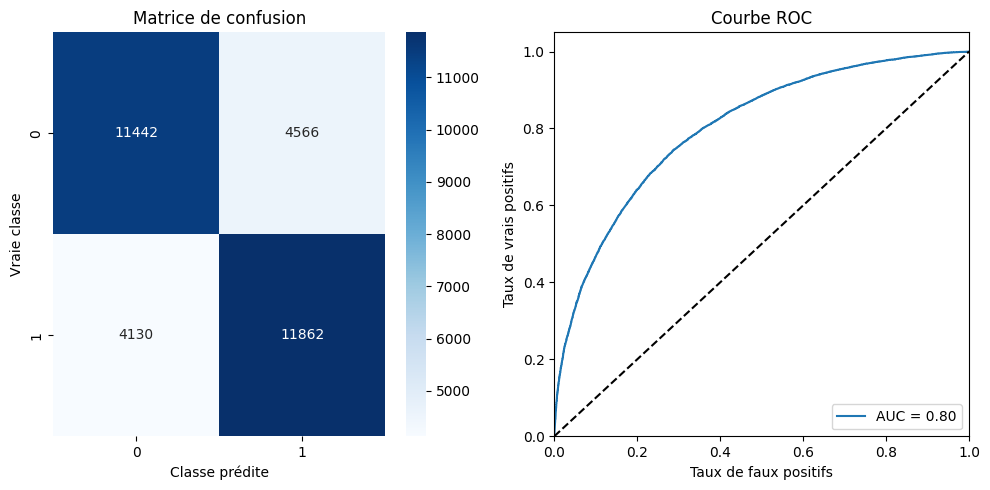

Registered model 'model_lr_word2vec' already exists. Creating a new version of this model...
Created version '3' of model 'model_lr_word2vec'.


In [6]:
# Créer et entraîner le modèle de régression logistique
model_lr_w2v = LogisticRegression(solver='liblinear',
                                  max_iter=1000)

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_lr_w2v.fit(X_train_w2v, y_train)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr_w2v,
                                                                       X_test_w2v,
                                                                       y_test)
    except KeyboardInterrupt:
        print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression_Word2Vec")  # Nom descriptif
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42) # Ajouter le random state

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression_Word2Vec")

    # Enregistrer le modèle avec mlflow
    mlflow.sklearn.log_model(model_lr_w2v,
                             "model_lr_word2vec",
                            input_example = X_train_w2v[:5],
                            registered_model_name="model_lr_word2vec") 

### 3.2.1 - MLP + TF-IDF

Epoch 1/10


2025-02-11 11:45:58.251399: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204800000 exceeds 10% of free system memory.


12800/12800 [==============================] - 48s 4ms/step - loss: 0.5190 - accuracy: 0.7439 - val_loss: 0.5030 - val_accuracy: 0.7540
Epoch 2/10
12800/12800 [==============================] - 47s 4ms/step - loss: 0.5013 - accuracy: 0.7561 - val_loss: 0.4998 - val_accuracy: 0.7541
Epoch 3/10
12800/12800 [==============================] - 45s 4ms/step - loss: 0.4940 - accuracy: 0.7599 - val_loss: 0.5000 - val_accuracy: 0.7548
Epoch 4/10
12800/12800 [==============================] - 45s 3ms/step - loss: 0.4870 - accuracy: 0.7641 - val_loss: 0.4998 - val_accuracy: 0.7564
Epoch 5/10
12800/12800 [==============================] - 47s 4ms/step - loss: 0.4799 - accuracy: 0.7687 - val_loss: 0.5059 - val_accuracy: 0.7548
Epoch 6/10
12800/12800 [==============================] - 47s 4ms/step - loss: 0.4725 - accuracy: 0.7730 - val_loss: 0.5094 - val_accuracy: 0.7565
Epoch 7/10
12800/12800 [==============================] - 46s 4ms/step - loss: 0.4662 - accuracy: 0.7769 - val_loss: 0.5073 - val

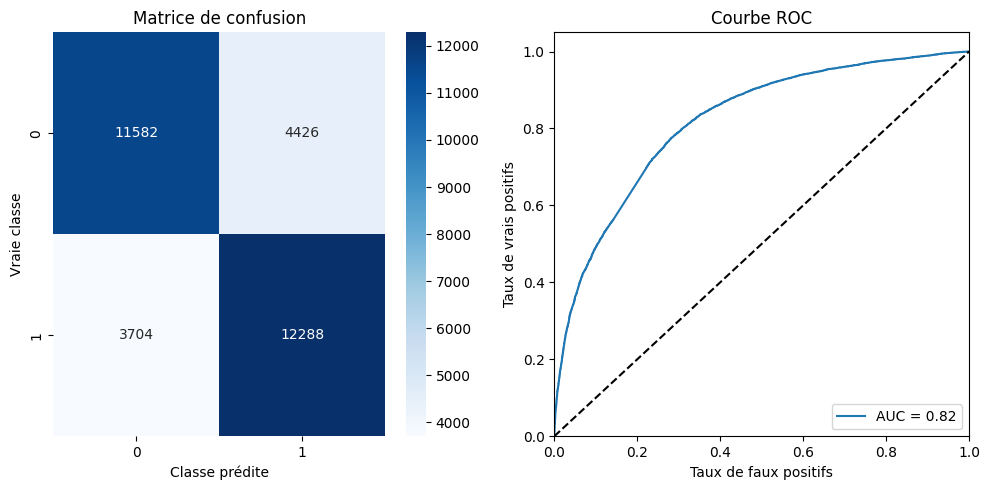

2025/02/11 11:53:48 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException("Unsupported input data type: <class 'scipy.sparse._csr.csr_matrix'>. Must be one of: ['ndarray', 'list', 'tuple', 'dict']"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`. To disable automatic signature inference, set `signature` to `False` in your `log_model` or `save_model` call.
2025/02/11 11:53:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpzzdukduw/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpzzdukduw/model/data/model/assets
2025/02/11 11:53:56 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
MlflowException("Unsupported input data type: <class 'scipy.sparse._csr.csr_matrix'>. Must be one of: ['ndarray', 'list', 'tuple', 'dict']")Traceback (most recent call last):


  File "/home/mehdi/Documents/OC/OC7/.venv/lib/python3.8/site-packages/mlflow/utils/_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)


  File "/home/mehdi/Documents/OC/OC7/.venv/lib/python3.8/site-packages/mlflow/tensorflow/__init__.py", line 897, in predict
    raise MlflowException(


mlflow.exceptions.MlflowException: Unsupported input data type: <class 'scipy.sparse._csr.csr_matrix'>. Must be one of: ['ndarray', 'list', 'tuple', 'dict']
Successfully registered model 'model_mlp_tfidf'.
Created version '1' of model 'model_mlp_tf

1/1 [==============================] - 0s 65ms/step


In [7]:
# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_tfidf.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Paramètres
        n_epochs = 10
        batch_size = 8
        # Entraîner le modèle
        model_mlp.fit(X_train_tfidf.toarray(),  # Convertir en array dense
                    y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp,
                                                                                  X_test_tfidf.toarray(),
                                                                                  y_test)

    except KeyboardInterrupt:
         print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "MLP_TFIDF")  # Nom descriptif
    mlflow.log_param("epochs", n_epochs)
    mlflow.log_param("batch_size", batch_size)

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "MLP_TFIDF")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp,
                           "model_mlp_tfidf",
                           input_example = X_train_tfidf[:5],
                          registered_model_name="model_mlp_tfidf")  

   


### 3.2.2 - MLP + Word2Vec

Epoch 1/10


2025-02-11 11:53:58.661899: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204800000 exceeds 10% of free system memory.


12800/12800 [==============================] - 50s 4ms/step - loss: 0.5741 - accuracy: 0.6997 - val_loss: 0.5613 - val_accuracy: 0.7126
Epoch 2/10
12800/12800 [==============================] - 49s 4ms/step - loss: 0.5604 - accuracy: 0.7121 - val_loss: 0.5458 - val_accuracy: 0.7202
Epoch 3/10
12800/12800 [==============================] - 54s 4ms/step - loss: 0.5566 - accuracy: 0.7156 - val_loss: 0.5507 - val_accuracy: 0.7184
Epoch 4/10
12800/12800 [==============================] - 49s 4ms/step - loss: 0.5538 - accuracy: 0.7177 - val_loss: 0.5442 - val_accuracy: 0.7217
Epoch 5/10
12800/12800 [==============================] - 47s 4ms/step - loss: 0.5516 - accuracy: 0.7189 - val_loss: 0.5483 - val_accuracy: 0.7234
Epoch 6/10
12800/12800 [==============================] - 50s 4ms/step - loss: 0.5512 - accuracy: 0.7196 - val_loss: 0.5447 - val_accuracy: 0.7209
Epoch 7/10
12800/12800 [==============================] - 53s 4ms/step - loss: 0.5499 - accuracy: 0.7202 - val_loss: 0.5445 - val

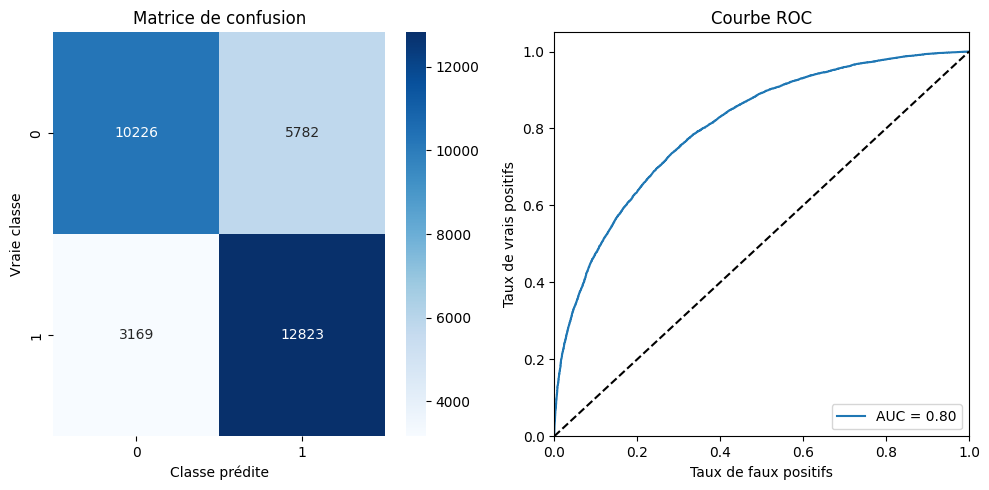

1/1 [==============================] - 0s 58ms/step
INFO:tensorflow:Assets written to: /tmp/tmps60m0gbm/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmps60m0gbm/model/data/model/assets
Successfully registered model 'model_mlp_word2vec'.
Created version '1' of model 'model_mlp_word2vec'.


1/1 [==============================] - 0s 60ms/step


In [8]:
# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_w2v.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_mlp.fit(X_train_w2v,
                      y_train,
                      epochs=10,
                      batch_size=8,
                      validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp,
                                                                                  X_test_w2v,
                                                                                  y_test)

    except KeyboardInterrupt:
        print("Entrainement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "MLP_Word2Vec") # Nom du modèle descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)
    # Ajoutez d'autres hyperparamètres si vous en avez

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "MLP_Word2Vec")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp,
                           "model_mlp_w2v",
                          input_example = X_train_w2v[:5],
                          registered_model_name="model_mlp_word2vec") 


### 3.3.1 - CNN + TF-IDF

In [ ]:
# Reshape des données TF-IDF pour le CNN (IMPORTANT: conversion en dense + ajout de la dimension canal)
X_train_cnn = X_train_tfidf.toarray()  # Convertit en array dense
X_train_cnn = np.reshape(X_train_cnn, (X_train_cnn.shape[0], X_train_cnn.shape[1], 1))

X_test_cnn = X_test_tfidf.toarray()  # Convertit en array dense
X_test_cnn = np.reshape(X_test_cnn, (X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

# Créer le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))  # input_shape correcte

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_cnn.fit(X_train_cnn,
                    y_train,
                    epochs=10,
                    batch_size=8,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_cnn,
                                                                                  X_test_cnn,
                                                                                  y_test)
    except KeyboardInterrupt:
        print("Entrainement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "CNN_TFIDF")  # Nom descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag
    mlflow.set_tag("model_name", "CNN_TFIDF")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn,
                           "model_cnn_tfidf",
                          input_example = X_train_cnn[:5],
                          registered_model_name="cnn_tfidf") 


Epoch 1/10


2025-02-11 12:02:32.722631: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204800000 exceeds 10% of free system memory.


12800/12800 [==============================] - 165s 13ms/step - loss: 0.5360 - accuracy: 0.7317 - val_loss: 0.5371 - val_accuracy: 0.7394
Epoch 2/10
12800/12800 [==============================] - 133s 10ms/step - loss: 0.5187 - accuracy: 0.7445 - val_loss: 0.5156 - val_accuracy: 0.7463
Epoch 3/10
12800/12800 [==============================] - 146s 11ms/step - loss: 0.5141 - accuracy: 0.7480 - val_loss: 0.5174 - val_accuracy: 0.7453
Epoch 4/10
12800/12800 [==============================] - 157s 12ms/step - loss: 0.5114 - accuracy: 0.7493 - val_loss: 0.5129 - val_accuracy: 0.7479
Epoch 5/10
12799/12800 [============================>.] - ETA: 0s - loss: 0.5096 - accuracy: 0.7497  

### 3.3.2 - CNN + Word2Vec

In [ ]:
# Reshape des données Word2Vec pour le modèle CNN
X_train_cnn = np.reshape(X_train_w2v, (X_train_w2v.shape[0], X_train_w2v.shape[1], 1))
X_test_cnn = np.reshape(X_test_w2v, (X_test_w2v.shape[0], X_test_w2v.shape[1], 1))

# Créer le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle
        model_cnn.fit(X_train_cnn,
                    y_train,
                    epochs=10,
                    batch_size=8,
                    validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_cnn, X_test_cnn, y_test)
    except KeyboardInterrupt:
        print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "CNN_Word2Vec")  # Nom de modèle descriptif
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 8)
    # Enregistrez d'autres hyperparamètres

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "CNN_Word2Vec")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn,
                           "model_cnn_w2v",
                          input_example = X_train_cnn[:5],
                          registered_model_name="cnn_tfidf") 


### 3.4 - LSTM + Word2Vec + Optimisation Batch size

In [ ]:
# Entraîner le modèle Word2Vec sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]
model_w2v = Word2Vec(sentences,
                     vector_size=500,
                     window=5,
                     min_count=1,
                     workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_w2v.wv), 500))

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_w2v.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_w2v.wv[word]

# Entraîner le modèle sur les données d'entraînement
X_train_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_length)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_length)

# Définir les valeurs de batch_size à tester
batch_sizes = [16, 32, 64, 128]

# Initialiser le meilleur batch_size et la meilleure accuracy
best_batch_size = None
best_accuracy = 0.0

for batch_size in batch_sizes:
    with mlflow.start_run():
        # Créer le modèle LSTM
        model_lstm = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                            embedding_matrix = embedding_matrix)

        # Entraîner le modèle avec le batch_size actuel
        model_lstm.fit(X_train_w2v, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm, X_test_w2v, y_test)

        # Enregistrer les paramètres
        mlflow.log_param("model", "LSTM")
        mlflow.log_param("embedding", "Word2Vec")
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", batch_size)

        # Enregistrer les métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

        # Ajouter un tag pour identifier le modèle
        mlflow.set_tag("model_name", "LSTM_w2v")

        # Enregistrer le modèle
        mlflow.keras.log_model(model_lstm,
                               "model_lstm_w2v",
                              registered_model_name="lstm_word2vec")

        # Mettre à jour le meilleur batch_size et la meilleure accuracy si nécessaire
        if accuracy > best_accuracy:
            best_batch_size = batch_size
            best_accuracy = accuracy

# Afficher le meilleur batch_size
print(f"Meilleur batch_size : {best_batch_size}")

### 3.5 - LSTM + FastText

model_ft = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4)

Le code ci-dessus crée un modèle Word2Vec en utilisant la librairie Gensim. Voici une explication des paramètres :

*   `sentences` : une liste de phrases tokenisées qui seront utilisées pour entraîner le modèle.
*   `vector_size` : la dimensionnalité des vecteurs de mots (word embeddings). Ici, chaque mot sera représenté par un vecteur de 100 dimensions.
*   `window` : la taille de la fenêtre de contexte. Le modèle va considérer 5 mots avant et 5 mots après chaque mot pour apprendre les relations entre les mots.
*   `min_count` : le nombre minimum d’occurrences d’un mot pour qu’il soit pris en compte dans le vocabulaire. Ici, tous les mots seront utilisés car `min_count=1`.
*   `workers` : le nombre de cœurs de processeur à utiliser pour l’entraînement.


In [ ]:


# Entraîner le modèle FastText sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]

vec_size = 300
model_ft = FastText(sentences, 
                    vector_size=vec_size,
                    window=5,
                    min_count=1,
                    workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_ft.wv), vec_size))  # Forme (vocab_size, vec_size)

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_ft.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_ft.wv[word]

# Définir le modèle LSTM avec la couche d'embedding FastText
model_lstm_ft = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                       embedding_matrix= embedding_matrix)

# Entraîner le modèle sur les données d'entraînement
X_train_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_ft = pad_sequences(X_train_ft, maxlen=max_length)
X_test_ft = pad_sequences(X_test_ft, maxlen=max_length)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    history = model_lstm_ft.fit(X_train_ft,
                                y_train,
                                epochs=10,
                                batch_size=16,
                                validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm_ft, X_test_ft, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("embedding", "FastText")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 16)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "LSTM_ft")

    # Enregistrer le modèle avec pickle
    with open('../models/model_lstm_ft.pkl', 'wb') as f:
        pickle.dump(model_lstm_ft, f)
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_lstm_ft,
                           "model_lstm_ft",
                          registered_model_name="lstm_fasttext")

### 3.6 - DistilBERT (1% des données)

In [ ]:
# --- Échantillonnage de 10% des données d'entraînement ---
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=0.1, stratify=y_train
)

# Créer et entraîner le modèle DistilBERT
model_distilbert, tokenizer = model.create_distilbert_model("distilbert-base-uncased")

# Tokenizer les tweets d'entraînement (échantillon) et de test
X_train_distilbert = tokenizer(X_train_small.tolist(),
                               padding=True,
                               truncation=True,
                               return_tensors="tf")

X_test_distilbert = tokenizer(X_test.tolist(),
                              padding=True,
                              truncation=True,
                              return_tensors="tf")

# Convertir les labels en tenseurs (échantillon et test)
y_train_distilbert = tf.convert_to_tensor(y_train_small)
y_test_distilbert = tf.convert_to_tensor(y_test)


# Hyperparamètres
batch_size = 8  # Vous pouvez ajuster
epochs = 3      # Vous pouvez ajuster

# Démarrer une exécution MLflow
with mlflow.start_run():
    try:
        # Entraîner le modèle (sur l'échantillon)
        history = model_distilbert.fit(
            x={"input_ids": X_train_distilbert["input_ids"],
               "attention_mask": X_train_distilbert["attention_mask"]},
            y=y_train_distilbert,
            validation_split=0.2,  # Utiliser une partie de l'échantillon pour la validation
            epochs=epochs,
            batch_size=batch_size,
        )

        # Évaluer le modèle (sur l'ensemble de test *complet*)
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele_bert(
            model_distilbert,
            {"input_ids": X_test_distilbert["input_ids"], 
             "attention_mask": X_test_distilbert["attention_mask"]},
            y_test_distilbert
        )
    except KeyboardInterrupt:
      print("Entraînement interrompu")

    # Enregistrer les paramètres
    mlflow.log_param("model", "DistilBERT")
    mlflow.log_param("model_name", "distilbert-base-uncased")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 5e-5)
    mlflow.log_param("train_size", 0.1)  # Log the training set size

    # Enregistrer les métriques
    if 'accuracy' in locals():
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "DistilBERT")
    mlflow.set_tag("train_size", "1%")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_distilbert,
                           "model_distilbert",
                          registered_model_name="distilbert")

### 3.7 - USE

In [ ]:
import tensorflow_hub as hub

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder les tweets
X_train_use = embed(X_train)
X_test_use = embed(X_test)

# Créer le modèle USE
model_use = model.create_use_model(input_shape=(X_train_use.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_use.fit(X_train_use,
                  y_train,
                  epochs=10,
                  batch_size=32,
                  validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_use,
                                                                              X_test_use,
                                                                              y_test)

    # Enregistrer les paramètres
    # (Ajouter ici les paramètres du modèle USE)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "USE")
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_use,
                           "model_use",
                          registered_model_name="use")

## 4. Comparaison des modèles

Erreur pour le modèle MLP_TFIDF: Aucune exécution trouvée avec le tag 'model_name' = 'MLP_TFIDF'
Erreur pour le modèle MLP_Word2Vec: Aucune exécution trouvée avec le tag 'model_name' = 'MLP_Word2Vec'
Erreur pour le modèle CNN_TFIDF: Aucune exécution trouvée avec le tag 'model_name' = 'CNN_TFIDF'
Erreur pour le modèle CNN_Word2Vec: Aucune exécution trouvée avec le tag 'model_name' = 'CNN_Word2Vec'
Erreur pour le modèle LSTM_w2v: Aucune exécution trouvée avec le tag 'model_name' = 'LSTM_w2v'
Erreur pour le modèle LSTM_ft: Aucune exécution trouvée avec le tag 'model_name' = 'LSTM_ft'
Erreur pour le modèle DistilBERT: Aucune exécution trouvée avec le tag 'model_name' = 'DistilBERT'
Erreur pour le modèle USE: Aucune exécution trouvée avec le tag 'model_name' = 'USE'


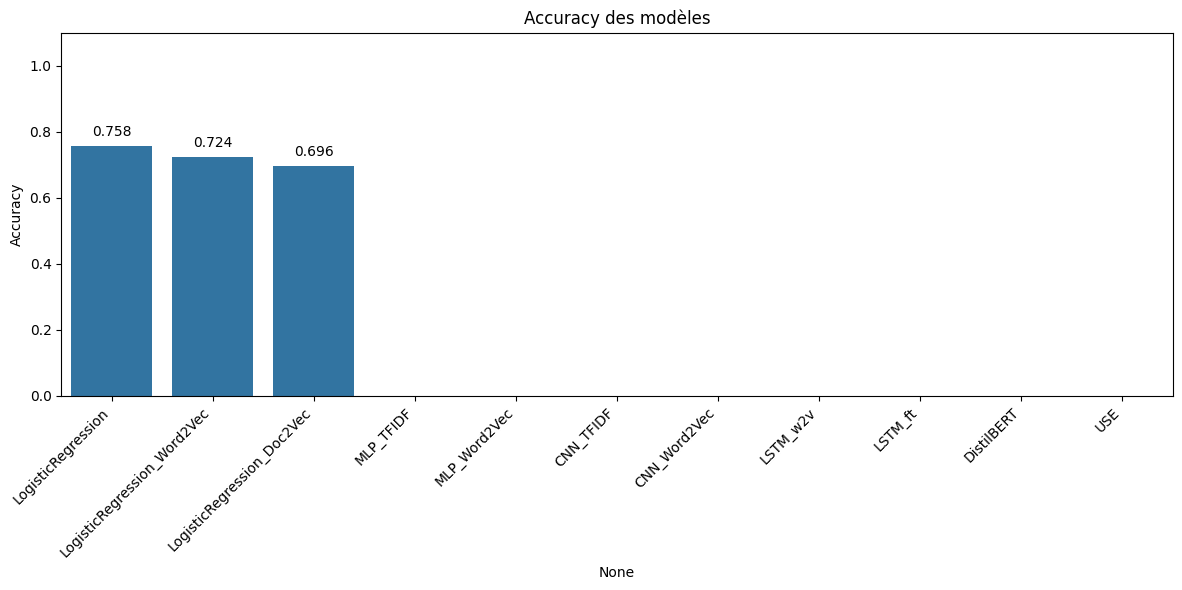

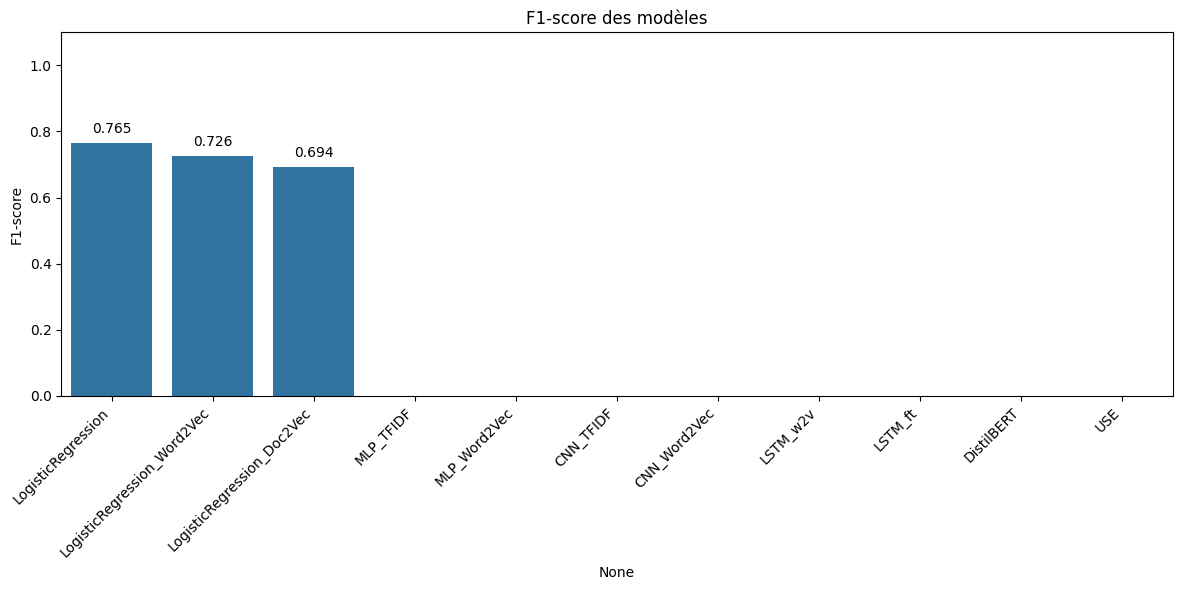

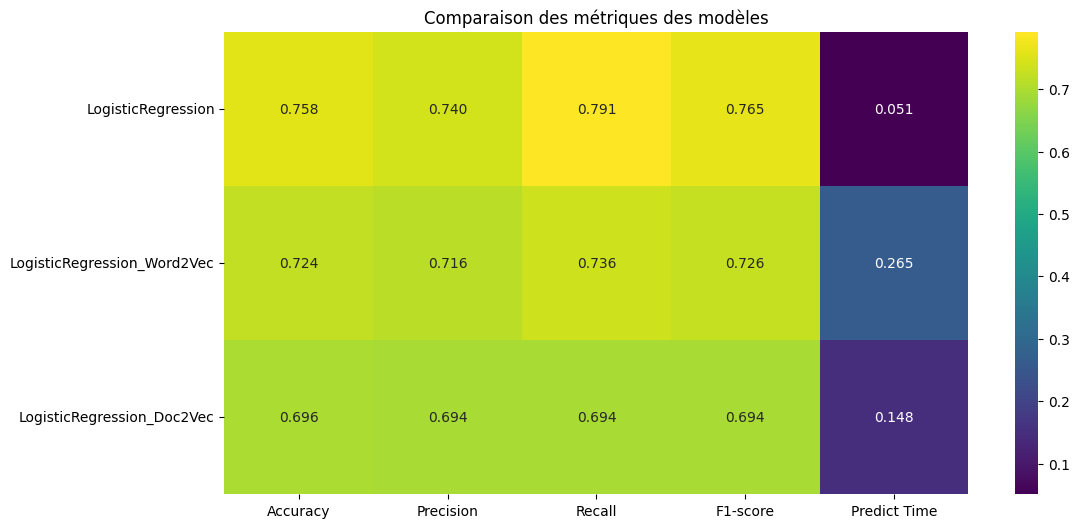

In [4]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour récupérer les métriques (inchangée)
def get_metrics_from_mlflow(model_name):
    runs = mlflow.search_runs(filter_string=f"tags.model_name = '{model_name}'")
    if runs.empty:
        raise ValueError(f"Aucune exécution trouvée avec le tag 'model_name' = '{model_name}'")
    last_run = runs.sort_values(by='start_time', ascending=False).iloc[0]
    return (
        last_run["metrics.accuracy"],
        last_run["metrics.precision"],
        last_run["metrics.recall"],
        last_run["metrics.f1_score"],
        last_run["metrics.predict_time"]
    )

# Liste des noms de modèles (assurez-vous qu'ils sont corrects!)
noms_modeles = [
    "LogisticRegression",  # Correction: ajout de _TFDIDF
    "LogisticRegression_Word2Vec",
    "LogisticRegression_Doc2Vec",
    "MLP_TFIDF",
    "MLP_Word2Vec",
    "CNN_TFIDF",
    "CNN_Word2Vec",
    "LSTM_w2v",
    "LSTM_ft",
    "DistilBERT",
    "USE"
]

# Calculer les métriques (avec gestion des erreurs)
resultats = []
for model_name in noms_modeles:
    try:
        resultats.append(get_metrics_from_mlflow(model_name))
    except ValueError as e:
        print(f"Erreur pour le modèle {model_name}: {e}")
        resultats.append((None, None, None, None, None))

# Créer le DataFrame
comparaison = pd.DataFrame(resultats, columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'Predict Time'], index=noms_modeles)

# --- Visualisation avec valeurs au-dessus des barres ---

# Bar plot pour l'accuracy
plt.figure(figsize=(12, 6))  # Légèrement plus large pour les labels
ax = sns.barplot(x=comparaison.index, y=comparaison['Accuracy'])  # Stocker l'objet Axes retourné par sns.barplot
plt.xticks(rotation=45, ha="right")
plt.title("Accuracy des modèles")
plt.ylim(0, 1.1)  # Ajuster la limite supérieure de l'axe y pour laisser de la place aux textes

# Ajouter les valeurs au-dessus des barres
for p in ax.patches:  # Boucle sur chaque barre (patch)
    if not pd.isna(p.get_height()): # Vérifier si la valeur n'est pas NaN
        ax.annotate(f"{p.get_height():.3f}",  # Formater la valeur à 3 décimales
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position (x, y) du texte
                    ha='center', va='center',  # Alignement horizontal et vertical
                    xytext=(0, 10),         # Décalage du texte par rapport à la barre
                    textcoords='offset points')  # Unités du décalage

plt.tight_layout()
plt.show()
# Bar plot pour le F1-score

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=comparaison.index, y=comparaison['F1-score'])
plt.xticks(rotation=45, ha="right")
plt.title("F1-score des modèles")
plt.ylim(0, 1.1)

for p in ax.patches:
    if not pd.isna(p.get_height()):
        ax.annotate(f"{p.get_height():.3f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
plt.tight_layout()
plt.show()


# --- Heatmap (optionnelle, inchangée) ---
plt.figure(figsize=(12, 6))
sns.heatmap(comparaison.dropna(), annot=True, cmap="viridis", fmt=".3f")
plt.title("Comparaison des métriques des modèles")
plt.show()